# **Noisy evaluation data removal (25/08)**

In [1]:
import os
import sys
import pandas as pd

curr_dir = os.getcwd()
lib_dir = os.path.join(curr_dir, '..', '..', 'notebooks')
if lib_dir not in sys.path:
    sys.path.insert(0,lib_dir)

from utils import plots, constants

## **Constants**

In [2]:
TUNING_FOLDER = constants.TUNING_FOLDER
LVL1_RESULTS = os.path.join(TUNING_FOLDER, 'lvl1.csv')
LVL2_RESULTS = os.path.join(TUNING_FOLDER, 'lvl2.csv')
LVL3_RESULTS = os.path.join(TUNING_FOLDER, 'lvl3.csv')

In [3]:
lvl3_df = pd.read_csv(LVL3_RESULTS)
lvl3_df.tail()

,date,model_name,source,target,score_type,score,epoch,parameters
2337,2023-08-17 10:07:15.623990,lvl3_grid_es_gn_s2s_from28_to30_seed38006_lear...,valid_es.txt.es,valid_gn.txt.gn,sacrebleu_corpus_bleu,23.121287,180,"{'type': ['s2s'], 'max-length-crop': [], 'drop..."
2338,2023-08-17 10:35:44.316526,lvl3_grid_es_gn_s2s_from24_to26_seed38006_lear...,valid_es.txt.es,valid_gn.txt.gn,sacrebleu_corpus_chrf,44.178655,80,"{'type': ['s2s'], 'max-length-crop': [], 'drop..."
2339,2023-08-17 10:35:44.316526,lvl3_grid_es_gn_s2s_from24_to26_seed38006_lear...,valid_es.txt.es,valid_gn.txt.gn,sacrebleu_corpus_bleu,22.063127,80,"{'type': ['s2s'], 'max-length-crop': [], 'drop..."
2340,2023-08-17 10:47:39.414848,lvl3_grid_es_gn_s2s_from28_to30_seed38006_lear...,valid_es.txt.es,valid_gn.txt.gn,sacrebleu_corpus_chrf,46.110570,190,"{'type': ['s2s'], 'max-length-crop': [], 'drop..."
2341,2023-08-17 10:47:39.414848,lvl3_grid_es_gn_s2s_from28_to30_seed38006_lear...,valid_es.txt.es,valid_gn.txt.gn,sacrebleu_corpus_bleu,23.261804,190,"{'type': ['s2s'], 'max-length-crop': [], 'drop..."


level 1

level 2

level 3

In [162]:
def get_constant_score_models(df: pd.DataFrame, all_constant=False):
    n_constant_limit = 2
    nunique_score_df = df.groupby(['model_name', 'score_type'])[['score']].nunique()
    if not all_constant:
        n_constant_limit = df.groupby(['model_name', 'score_type'])['epoch'].nunique()
    to_delete_models_unique = nunique_score_df[nunique_score_df['score'] < n_constant_limit].reset_index()['model_name'].unique().tolist()
    to_delete_models_df = df[df['model_name'].isin(to_delete_models_unique)]
    return to_delete_models_df

def remove_constant_score_models(df: pd.DataFrame, to_delete_models_df: pd.DataFrame):
    kept_models_df = df[~df['model_name'].isin(to_delete_models_df['model_name'])]
    return kept_models_df

In [163]:
MAX_EPOCHS = 1000
EARLY_STOPPING_PATIENCE = 7

def find_non_early_stopped_models(kept_models_df: pd.DataFrame, early_stopping_patience = EARLY_STOPPING_PATIENCE, max_epochs=MAX_EPOCHS):
    last_model = None
    kept_models_chrf = kept_models_df[kept_models_df['score_type'] == 'sacrebleu_corpus_chrf']
    idx_since_best = 0
    non_early_stopped_models = []
    last_epoch = None

    for _, row in kept_models_chrf.sort_values(['model_name', 'epoch']).iterrows():
        if row['model_name'] != last_model:
            if last_model is not None and early_stopping_patience > idx_since_best \
               and last_epoch is not None and last_epoch < max_epochs:
                non_early_stopped_models.append(row['model_name'])
            best_score = 0
            last_model = row['model_name']

        idx_since_best += 1
        last_epoch = row['epoch']

        if row['score'] > best_score:
            best_score = row['score']
            idx_since_best = 0

    return non_early_stopped_models

In [164]:
def get_short_period_models(df: pd.DataFrame, max_len=7):
    return df.groupby(['model_name', 'score_type']).filter(lambda x: len(x.index) < max_len)

## **GN -> ES**

In [165]:
gn_es_lvl3_results = lvl3_df[lvl3_df['source'].str.contains('gn', regex=False)]

In [166]:
to_delete_models_df = get_constant_score_models(gn_es_lvl3_results)
kept_models_df = remove_constant_score_models(gn_es_lvl3_results, to_delete_models_df)

f:\my_year2023\PLN\code\MARIAN\scripts\migrations\..\..\notebooks\utils\plots.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


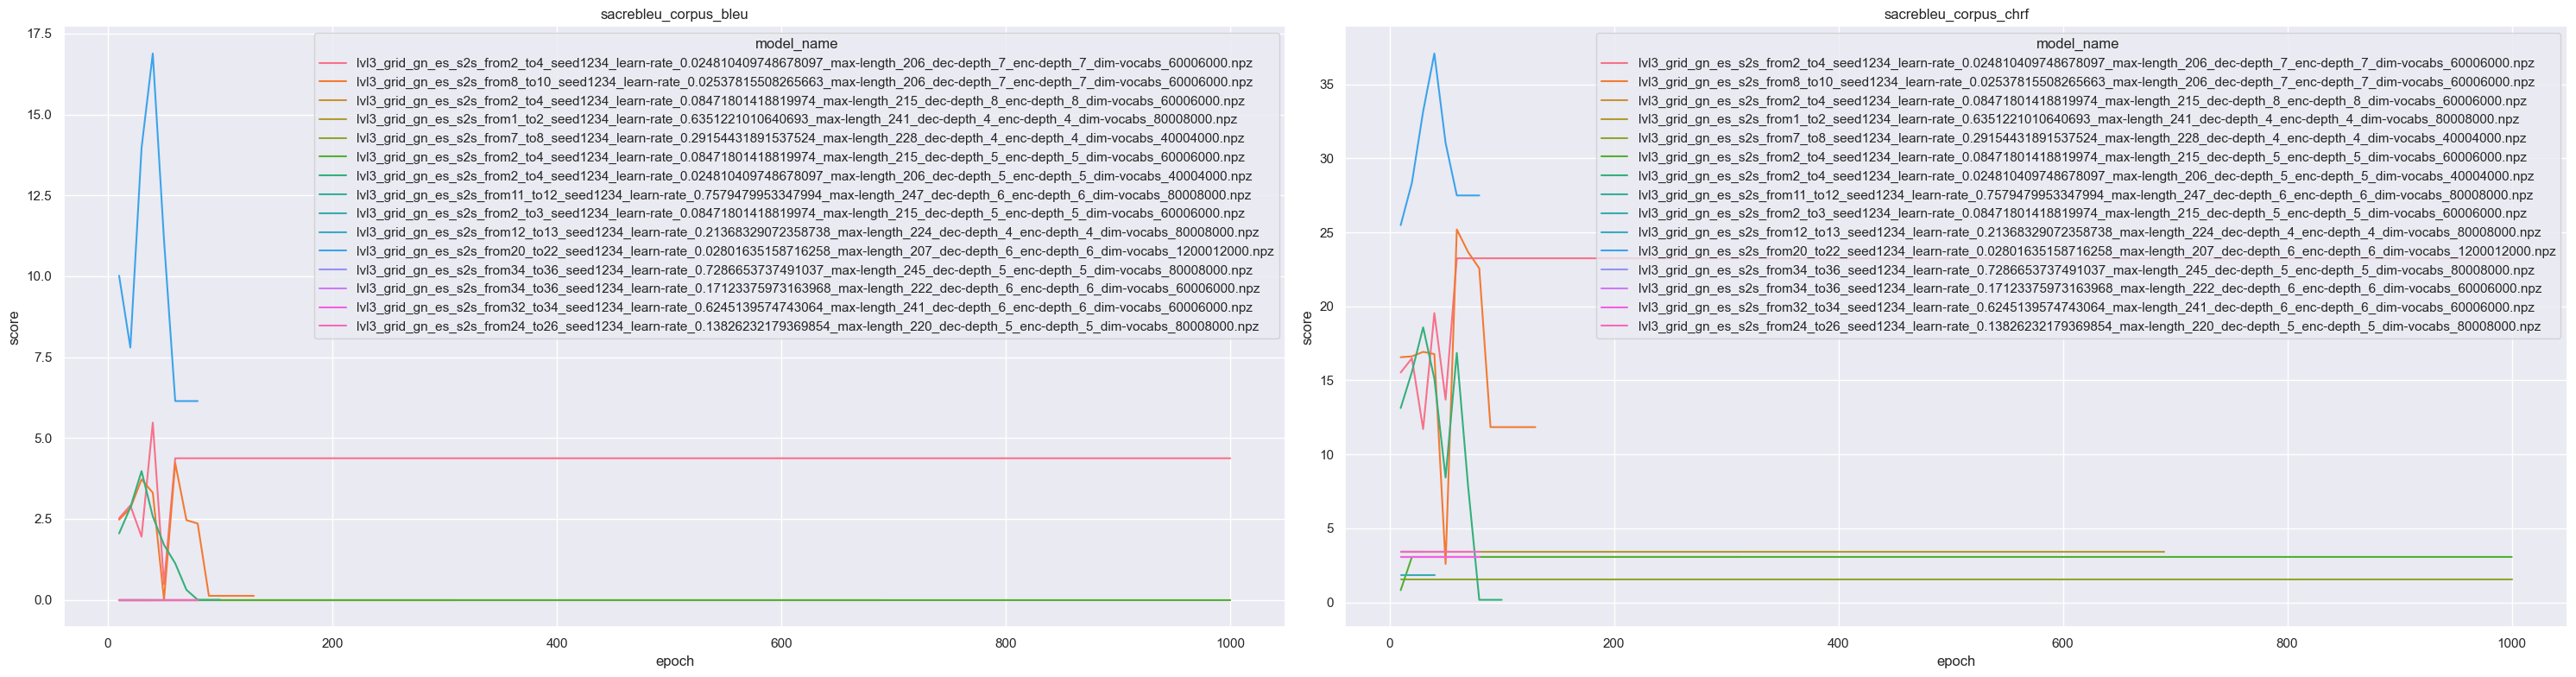

In [167]:
plots.plot_metric_by_epoch_foreach_model(to_delete_models_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=(30,8));

f:\my_year2023\PLN\code\MARIAN\scripts\migrations\..\..\notebooks\utils\plots.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


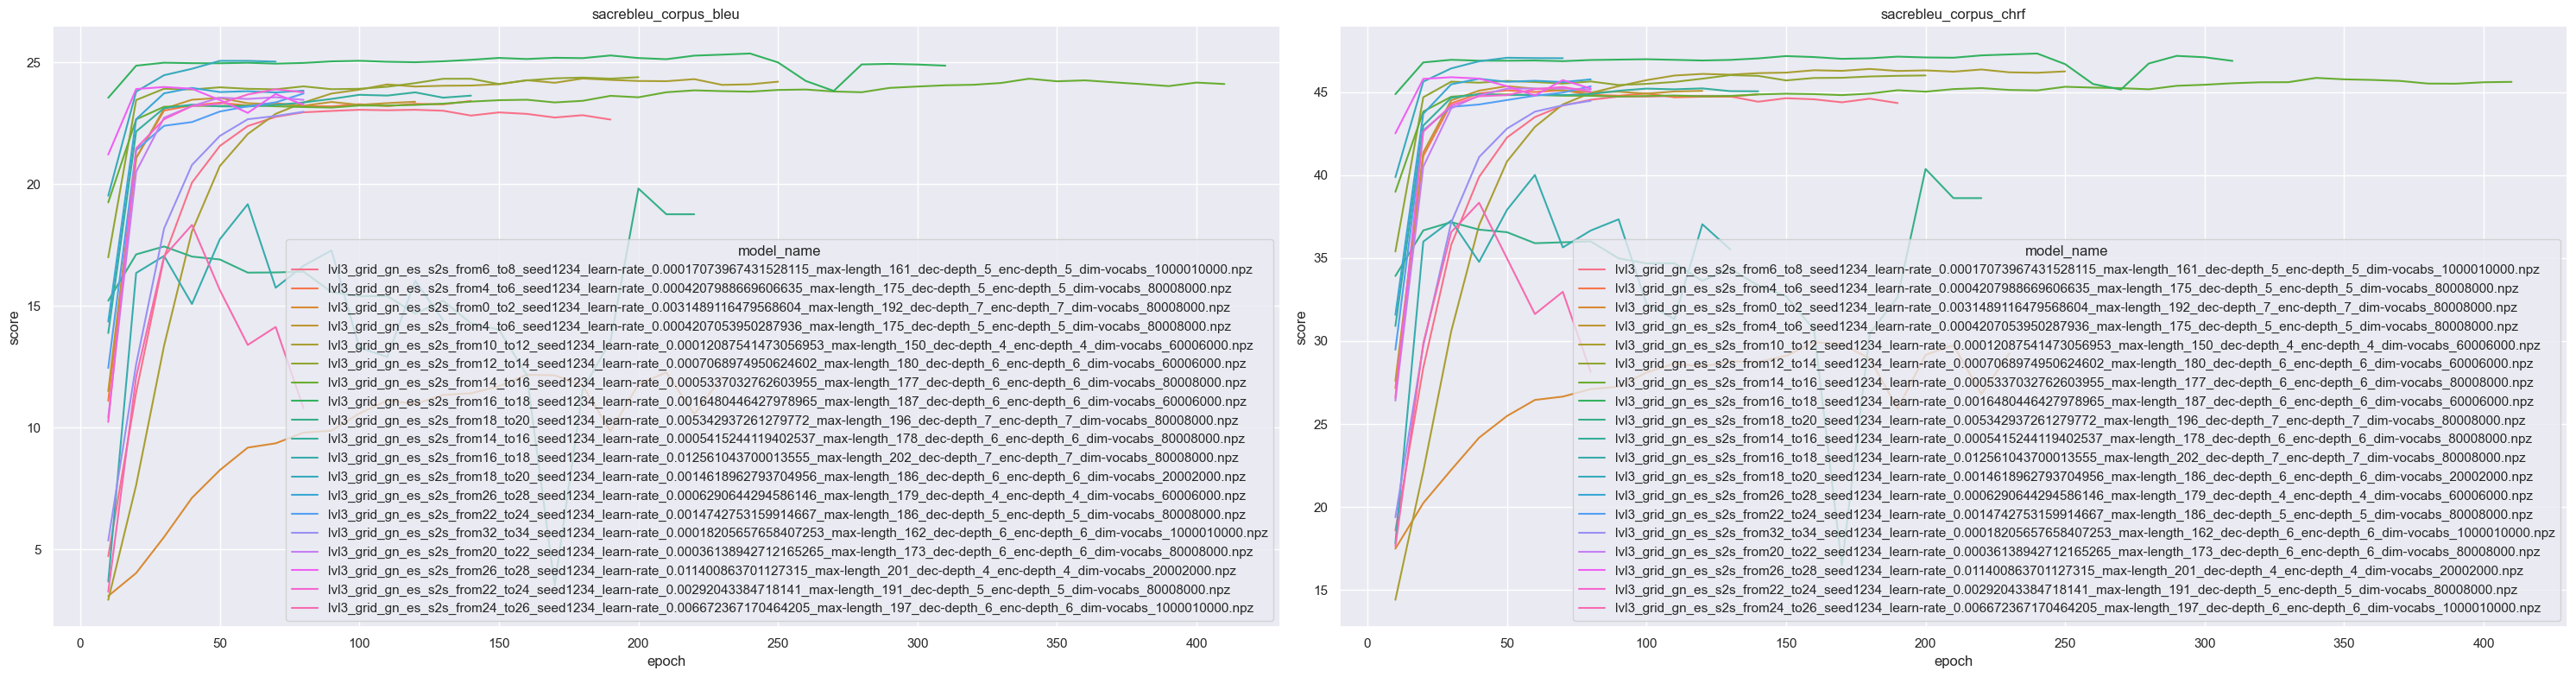

In [168]:
plots.plot_metric_by_epoch_foreach_model(kept_models_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=(30,8));

In [169]:
len(kept_models_df['model_name'].unique())

19

In [170]:
find_non_early_stopped_models(kept_models_df)

['lvl3_grid_gn_es_s2s_from16_to18_seed1234_learn-rate_0.0016480446427978965_max-length_187_dec-depth_6_enc-depth_6_dim-vocabs_60006000.npz',
 'lvl3_grid_gn_es_s2s_from18_to20_seed1234_learn-rate_0.005342937261279772_max-length_196_dec-depth_7_enc-depth_7_dim-vocabs_80008000.npz',
 'lvl3_grid_gn_es_s2s_from22_to24_seed1234_learn-rate_0.0014742753159914667_max-length_186_dec-depth_5_enc-depth_5_dim-vocabs_80008000.npz',
 'lvl3_grid_gn_es_s2s_from22_to24_seed1234_learn-rate_0.00292043384718141_max-length_191_dec-depth_5_enc-depth_5_dim-vocabs_80008000.npz',
 'lvl3_grid_gn_es_s2s_from24_to26_seed1234_learn-rate_0.006672367170464205_max-length_197_dec-depth_6_enc-depth_6_dim-vocabs_1000010000.npz',
 'lvl3_grid_gn_es_s2s_from26_to28_seed1234_learn-rate_0.0006290644294586146_max-length_179_dec-depth_4_enc-depth_4_dim-vocabs_60006000.npz',
 'lvl3_grid_gn_es_s2s_from26_to28_seed1234_learn-rate_0.011400863701127315_max-length_201_dec-depth_4_enc-depth_4_dim-vocabs_20002000.npz',
 'lvl3_grid_gn_e

In [171]:
get_short_period_models(kept_models_df)

,date,model_name,source,target,score_type,score,epoch,parameters


## **ES -> GN**

In [172]:
es_gn_lvl3_results = lvl3_df[lvl3_df['source'].str.contains('es', regex=False)]
es_gn_lvl3_results_2 = pd.read_csv(os.path.join(TUNING_FOLDER, 'lvl3_s2s_es_gn.csv'))

es_gn_lvl3_total_results_df = pd.concat([es_gn_lvl3_results, es_gn_lvl3_results_2])

In [173]:
to_delete_es_gn_models_df = get_constant_score_models(es_gn_lvl3_total_results_df)
kept_es_gn_models_df = remove_constant_score_models(es_gn_lvl3_total_results_df, to_delete_es_gn_models_df)

f:\my_year2023\PLN\code\MARIAN\scripts\migrations\..\..\notebooks\utils\plots.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


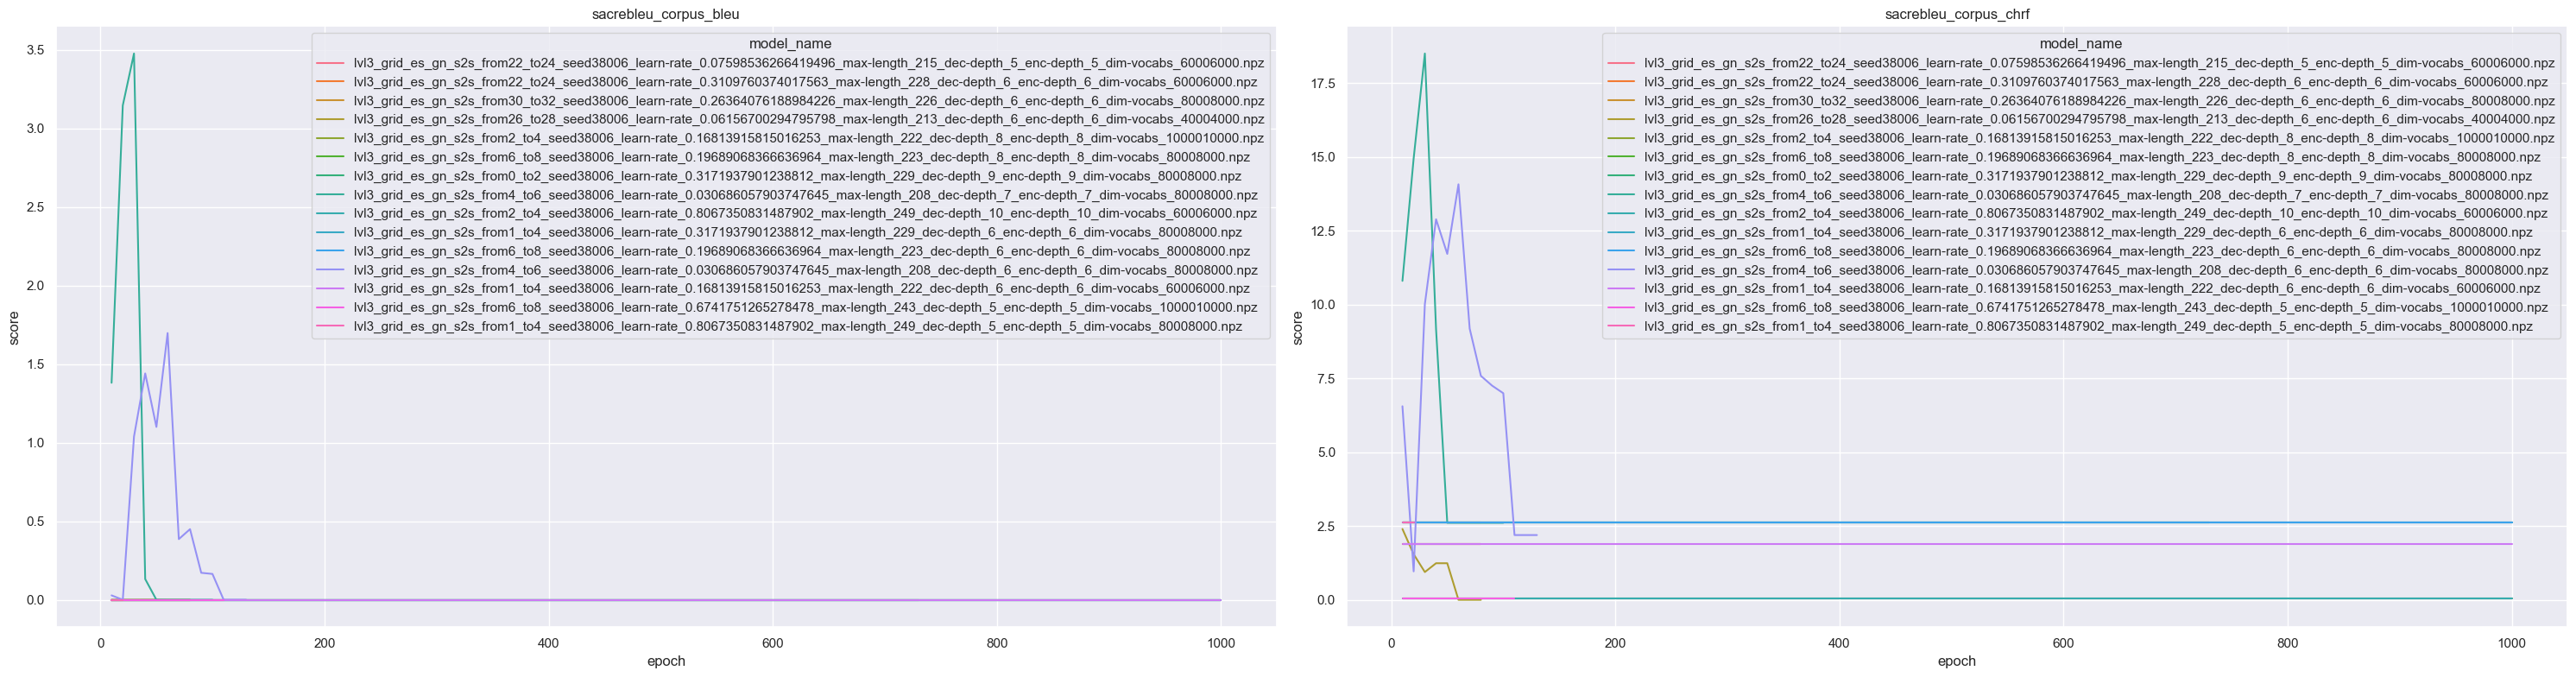

In [174]:
plots.plot_metric_by_epoch_foreach_model(to_delete_es_gn_models_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=(30,8));

f:\my_year2023\PLN\code\MARIAN\scripts\migrations\..\..\notebooks\utils\plots.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


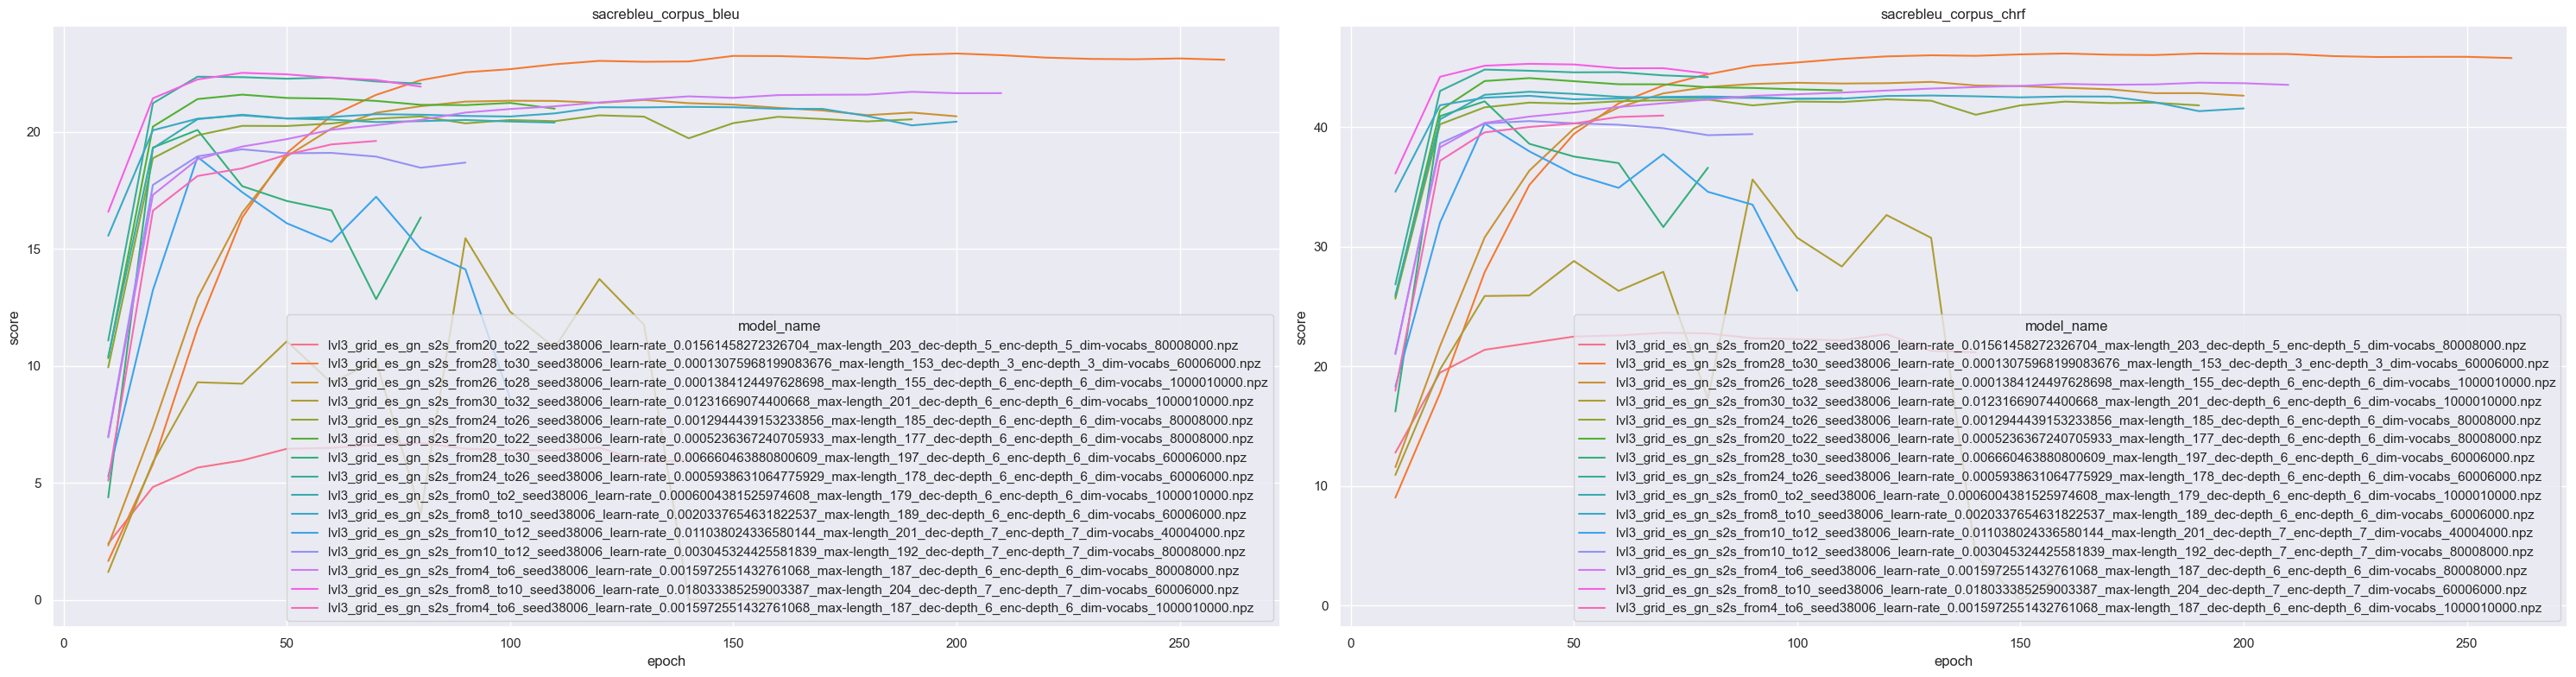

In [175]:
plots.plot_metric_by_epoch_foreach_model(kept_es_gn_models_df, metrics=['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'], figsize=(30,8));

In [176]:
len(kept_es_gn_models_df['model_name'].unique())

15

In [177]:
find_non_early_stopped_models(kept_es_gn_models_df)

['lvl3_grid_es_gn_s2s_from4_to6_seed38006_learn-rate_0.0015972551432761068_max-length_187_dec-depth_6_enc-depth_6_dim-vocabs_80008000.npz',
 'lvl3_grid_es_gn_s2s_from8_to10_seed38006_learn-rate_0.0020337654631822537_max-length_189_dec-depth_6_enc-depth_6_dim-vocabs_60006000.npz']

In [178]:
get_short_period_models(kept_es_gn_models_df)

,date,model_name,source,target,score_type,score,epoch,parameters
